# Sudoku solver

In classic Sudoku, the objective is to fill a 9 × 9 grid with digits so that each column, each row, and each of the nine 3 × 3 subgrids that compose the grid (also called "boxes", "blocks", or "regions") contains all of the digits from 1 to 9.

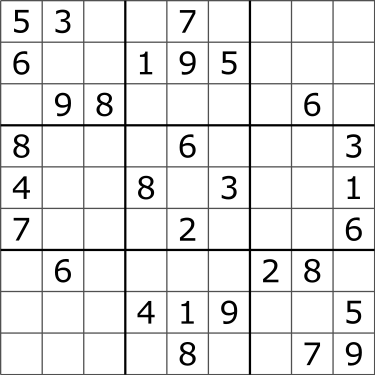

## Prepare environment

In [1]:
import kagglehub
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras import layers, optimizers, losses, metrics, models, callbacks, regularizers
import pathlib
from matplotlib import pyplot as plt
import datetime
from sklearn.model_selection import StratifiedShuffleSplit
import shutil

# Enable mixed precision training to speed up computation
# WARNING: turn off if you run this on CPU - it will significantly slow down training
# https://keras.io/api/mixed_precision/
# 
# Enable when training takes too long - it lowered training time by 14% and increased error rate by 16%
# keras.mixed_precision.set_global_policy("mixed_float16")

# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
keras.utils.set_random_seed(42)

# If using TensorFlow, this will make GPU ops as deterministic as possible,
# but it will affect the overall performance, so be mindful of that.
# tf.config.experimental.enable_op_determinism()

MODEL_FILE_NAME = "sudoku_solver.keras"

2025-04-27 18:45:13.505744: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745772313.632413   99891 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745772313.671738   99891 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-27 18:45:13.983175: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Hyperparameters

In [2]:
DATA_SIZE_LIMIT = None

BATCH_SIZE = 256 # 8192 # Best accurracy & time for current learning rate
LEARNING_RATE = 1e-3
EPOCHS = 3

# Use residual connections in convolutional model architecture
USE_RESIDUAL = True

# Idea is to pretrain model on solution-only data (self-supervised learning) like autoencoder
#
# There is no performance improvement on small data sample (10%) and few epochs training (1)
# Turn on when training with more data and epochs to see if it helps
USE_PRE_TRAINING = False

## Prepare dataset

### Save preprocessed puzzles to disk

In [ ]:
# Helper function to create a BytesList feature
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy()
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

# Function to create a tf.train.Example from preprocessed tensors
def create_tf_example(input_tensor, target_tensor):
    """Creates a tf.train.Example message ready to be written to a file."""
    # Convert tensors to byte strings
    input_bytes = tf.io.serialize_tensor(input_tensor) # Efficiently serializes tensor to byte string
    target_bytes = tf.io.serialize_tensor(target_tensor)

    # Create a dictionary mapping feature keys to tf.train.Feature proto objects
    feature = {
        'input': _bytes_feature(input_bytes),
        'target': _bytes_feature(target_bytes),
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

In [3]:
# --- Configuration ---
TFRECORD_DIR = "./sudoku_tfrecords"  # Directory to save the TFRecord files
NUM_SHARDS = 100  # Number of TFRecord files to split the data into (e.g., 100 files for 9M examples = 90k examples per file)
# Consider using compression for smaller file size (at cost of CPU when reading)
COMPRESSION_TYPE = "GZIP"  # 'GZIP' or None

In [ ]:
# Create output directory
os.makedirs(TFRECORD_DIR, exist_ok=True)

# --- Create the raw input dataset ---
# Read puzzles and targets simultaneously
# Use num_parallel_reads for faster file reading if you split input into smaller files
raw_dataset = tf.data.Dataset.from_tensor_slices((X_tensors, y_tensors))

# --- Apply Preprocessing ---
# Use num_parallel_calls to parallelize preprocessing across CPU cores
preprocessed_dataset = raw_dataset.map(
    preprocess_map, num_parallel_calls=tf.data.AUTOTUNE
)

# --- Serialize to TF Examples ---
# Map the serialization function over the preprocessed dataset
# Use parallel calls if serialization itself becomes a bottleneck (less likely than preprocessing)
serialized_dataset = preprocessed_dataset.map(
    lambda x, y: tf.py_function(
        func=lambda a, b: create_tf_example(a, b).SerializeToString(),
        inp=[x, y],
        Tout=tf.string,
    ),
    num_parallel_calls=tf.data.AUTOTUNE,
)

# Add a 0-based index to each element
# The dataset elements are now tuples: (index, serialized_example_string)
indexed_serialized_dataset = serialized_dataset.enumerate()

# --- Write to TFRecords ---
# Use Dataset.save() to write to multiple sharded files efficiently
# This handles iterating through the dataset and writing in parallel
output_pattern = os.path.join(
    TFRECORD_DIR, "sudoku_part_{:05d}".format(0)
)  # Tensorflow will add -of-NUM_SHARDS

tf.data.Dataset.save(
    indexed_serialized_dataset,
    path=output_pattern,  # TODO: this should be just path to root shard directory
    compression=COMPRESSION_TYPE,
    # The lambda function now receives the tuple (index, element)
    # Use the 'index' (the first item in the tuple) for sharding
    shard_func=lambda index, element: index % NUM_SHARDS
)

print(
    f"Preprocessing complete. TFRecords saved to {TFRECORD_DIR} in {NUM_SHARDS} shards."
)

In [4]:
# --- Define Parsing Function ---
def parse_tf_example(index, example_proto):
    """Parses a serialized tf.train.Example proto into tensors."""
    # Define the features to be parsed
    feature_description = {
        'input': tf.io.FixedLenFeature([], tf.string), # Stored as byte string
        'target': tf.io.FixedLenFeature([], tf.string), # Stored as byte string
    }

    print(example_proto)

    # Parse the example
    parsed_features = tf.io.parse_single_example(example_proto, feature_description)

    # Deserialize the byte strings back into tensors
    # Need to know the original shape and dtype
    input_tensor = tf.io.parse_tensor(parsed_features['input'], out_type=tf.double)
    target_tensor = tf.io.parse_tensor(parsed_features['target'], out_type=tf.int32)

    # Reshape back to the original (9, 9, 1) shape (parse_tensor might flatten)
    input_tensor = tf.reshape(input_tensor, (9, 9, 1))
    target_tensor = tf.reshape(target_tensor, (9, 9, 1))

    return input_tensor, target_tensor

In [5]:
parsed_dataset = tf.data.Dataset.load(
    os.path.join(TFRECORD_DIR, "sudoku_part_00000"),
    compression=COMPRESSION_TYPE,
    element_spec=(
        tf.TensorSpec(shape=(), dtype=tf.int64),  # This is the index
        tf.TensorSpec(shape=(), dtype=tf.string), # This is the serialized example
    ),  
)

# Map the parsing function over the dataset
train_dataset = (
    parsed_dataset.map(parse_tf_example, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .shuffle(buffer_size=100000, reshuffle_each_iteration=True)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

I0000 00:00:1745772339.993140   99891 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2874 MB memory:  -> device: 0, name: Quadro P600, pci bus id: 0000:01:00.0, compute capability: 6.1


Tensor("args_1:0", shape=(), dtype=string)


In [9]:
training_callbacks = prepare_callbacks()

train_batch_size = sum(1 for _ in train_dataset)

model.fit(
        train_dataset.take(int(train_batch_size * 0.95)),
        validation_data=train_dataset.skip(int(train_batch_size * 0.95)),
        epochs=EPOCHS,
        callbacks=training_callbacks,
    )

2025-04-27 18:46:06.966868: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:103] Profiler session initializing.
2025-04-27 18:46:06.966925: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:118] Profiler session started.
2025-04-27 18:46:06.966978: I external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1006] Profiler found 1 GPUs
2025-04-27 18:46:07.012246: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:130] Profiler session tear down.
2025-04-27 18:46:07.012487: I external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1213] CUPTI activity buffer flushed


Epoch 1/3


2025-04-27 18:54:19.597644: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
I0000 00:00:1745772869.106647  100094 service.cc:148] XLA service 0x7f9588003020 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745772869.108380  100094 service.cc:156]   StreamExecutor device (0): Quadro P600, Compute Capability 6.1
2025-04-27 18:54:29.563493: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745772870.575294  100094 cuda_dnn.cc:529] Loaded cuDNN version 90700
2025-04-27 18:54:32.217020: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[256,64,9,9]{3,2,1,0}, u8[0]{0}) custom-call(f32[256,64,9,9]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad

20000/33398 ━━━━━━━━━━━━━━━━━━━━ 25:09 113ms/step - accuracy: 0.7600 - loss: 0.7454

2025-04-27 19:32:17.568755: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:103] Profiler session initializing.
2025-04-27 19:32:17.568817: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:118] Profiler session started.


20005/33398 ━━━━━━━━━━━━━━━━━━━━ 25:08 113ms/step - accuracy: 0.7601 - loss: 0.7453

2025-04-27 19:32:18.302615: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:68] Profiler session collecting data.
2025-04-27 19:32:18.334634: I external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1213] CUPTI activity buffer flushed
2025-04-27 19:32:18.395923: I external/local_xla/xla/backends/profiler/gpu/cupti_collector.cc:635]  GpuTracer has collected 2286 callback api events and 2253 activity events. 
2025-04-27 19:32:18.395994: I external/local_xla/xla/backends/profiler/gpu/cupti_collector.cc:638]  GpuTracer max callback_events: 2097152, max activity events: 2097152
2025-04-27 19:32:18.438175: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:130] Profiler session tear down.
2025-04-27 19:32:18.452022: I external/local_xla/xla/tsl/profiler/rpc/client/save_profile.cc:147] Collecting XSpace to repository: logs/fit/20250427-184606/train/plugins/profile/2025_04_27_19_32_18/DESKTOP-NA0PLVR.xplane.pb


33398/33398 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.7915 - loss: 0.6603

2025-04-27 19:58:46.471334: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1813985280 exceeds 10% of free system memory.


33398/33398 ━━━━━━━━━━━━━━━━━━━━ 3895s 116ms/step - accuracy: 0.7915 - loss: 0.6603 - val_accuracy: 0.8889 - val_loss: 0.3859 - learning_rate: 0.0010
Epoch 2/3


2025-04-27 19:59:30.399900: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 1 of 100000
2025-04-27 19:59:30.505111: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


33398/33398 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.8854 - loss: 0.4026

2025-04-27 21:03:03.909846: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1813985280 exceeds 10% of free system memory.


33398/33398 ━━━━━━━━━━━━━━━━━━━━ 3837s 114ms/step - accuracy: 0.8854 - loss: 0.4026 - val_accuracy: 0.8976 - val_loss: 0.3600 - learning_rate: 0.0010
Epoch 3/3
33398/33398 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.8928 - loss: 0.3804

2025-04-27 22:06:50.883386: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1813985280 exceeds 10% of free system memory.


33398/33398 ━━━━━━━━━━━━━━━━━━━━ 3826s 114ms/step - accuracy: 0.8928 - loss: 0.3804 - val_accuracy: 0.9010 - val_loss: 0.3472 - learning_rate: 0.0010


In [12]:
model.save(MODEL_FILE_NAME)

### Download from Kaggle

In [ ]:
path = kagglehub.dataset_download("rohanrao/sudoku")
print("Path to dataset files:", path)

In [ ]:
os.listdir(path)

In [ ]:
FILE_PATH = os.path.join(path, "sudoku.csv")

In [ ]:
sudoku_text = pathlib.Path(FILE_PATH).read_text()

In [ ]:
sudoku_lines = sudoku_text.split("\n")[1:-1]  # Drop header

del sudoku_text

In [ ]:
if (DATA_SIZE_LIMIT != None):
    sudoku_lines = sudoku_lines[:DATA_SIZE_LIMIT]

In [ ]:
full_dataset_size = len(sudoku_lines)
print(full_dataset_size)

### Decode CSV to tensor list

In [ ]:
sudoku_tensors = np.array(tf.io.decode_csv(sudoku_lines, record_defaults=[str()] * 2))
print(f"Decoded CSV shape: {sudoku_tensors.shape}")

del sudoku_lines

### Split train, validation and test sets based on difficulty

In [ ]:
X_tensors, y_tensors = sudoku_tensors

In [ ]:
def calculate_difficulties(X_tensors):
    # Count zero entries (given clues) - the more zeros the more difficult is the puzzle
    difficulties = np.array([puzzle.decode("utf-8").count("0") for puzzle in X_tensors])
    return difficulties

In [ ]:
difficulties = calculate_difficulties(X_tensors)

# Replace difficulties with rare occurrence with the most common one so that we can split evenly
difficulty_counts = np.bincount(difficulties)
rare_difficulties = np.where(difficulty_counts < 100)[0]
most_common_difficulty = np.argmax(difficulty_counts)
difficulties = np.where(np.isin(difficulties, rare_difficulties), most_common_difficulty, difficulties)

print("Original difficulty distribution:", np.bincount(difficulties))

In [ ]:
# We have enough data so 2.5% for test and val sets is enough (still 225k)
train_sss = StratifiedShuffleSplit(n_splits=1, test_size=0.05, random_state=42)
train_index, test_index = next(train_sss.split(X_tensors, difficulties))
difficulties_train = difficulties[train_index]
difficulties_train_dist = np.round(100 * np.bincount(difficulties_train) / len(difficulties_train), 2)
print("Train difficulty distribution (percentage):", difficulties_train_dist)

X_train_tensors, X_temp, y_train_tensors, y_temp = X_tensors[train_index], X_tensors[test_index], y_tensors[train_index], y_tensors[test_index]
difficulties_temp = difficulties[test_index]

test_sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_index, test_index = next(test_sss.split(X_temp, difficulties_temp))
X_val_tensors, X_test_tensors, y_val_tensors, y_test_tensors = X_temp[val_index], X_temp[test_index], y_temp[val_index], y_temp[test_index]

difficulties_val = difficulties_temp[val_index]
difficulties_val_dist = np.round(100 * np.bincount(difficulties_val) / len(difficulties_val), 2)
print("Val difficulty distribution (percentage):", difficulties_val_dist)

difficulties_test = difficulties_temp[test_index]
difficulties_test_dist = np.round(100 * np.bincount(difficulties_test) / len(difficulties_test), 2)
print("Test difficulty distribution (percentage):", difficulties_test_dist)

# Calculate the difference between the distributions
train_val_diff = difficulties_train_dist - difficulties_val_dist
train_test_diff = difficulties_train_dist - difficulties_test_dist
val_test_diff = difficulties_val_dist - difficulties_test_dist

# Print the differences
print("Difference between train and validation difficulty distribution (percentage):", train_val_diff)
print("Difference between train and test difficulty distribution (percentage):", train_test_diff)
print("Difference between validation and test difficulty distribution (percentage):", val_test_diff)

del X_tensors, y_tensors, X_temp, y_temp

#### Validate splits

In [ ]:
train_difficulty_10_sample = X_train_tensors[np.where(difficulties_train == 10)[0]][:5]
print(train_difficulty_10_sample)

[puzzle.decode("utf-8").count("0") for puzzle in train_difficulty_10_sample]

In [ ]:
val_difficulty_20_sample = X_val_tensors[np.where(difficulties_val == 20)[0]][:5]
print(val_difficulty_20_sample)

[puzzle.decode("utf-8").count("0") for puzzle in val_difficulty_20_sample]

In [ ]:
test_difficulty_30_sample = X_test_tensors[np.where(difficulties_test == 30)[0]][:5]
print(test_difficulty_30_sample)

[puzzle.decode("utf-8").count("0") for puzzle in test_difficulty_30_sample]

In [ ]:
print(f"Train size: {len(X_train_tensors)}")
print(f"Validation size: {len(X_val_tensors)}")
print(f"Test size: {len(X_test_tensors)}")

### Sort train set by difficulty

In [ ]:
def apply_curriculum_learning(X_tensors, y_tensors):
    # Sort data by increasing difficulty
    sorted_indices = np.argsort(difficulties_train)
    X_tensors_sorted = X_tensors[sorted_indices]
    y_tensors_sorted = y_tensors[sorted_indices]
    return X_tensors_sorted, y_tensors_sorted

In [ ]:
# Sorted by difficulty (from easier to harder)
X_train_tensors_sorted, y_train_tensors_sorted = apply_curriculum_learning(X_train_tensors, y_train_tensors)

In [ ]:
X_train_tensors_sorted[:5]

In [ ]:
X_train_tensors_sorted[-5:]

In [ ]:
val_sudoku_ds = tf.data.Dataset.from_tensor_slices((X_val_tensors, y_val_tensors))
test_sudoku_ds = tf.data.Dataset.from_tensor_slices((X_test_tensors, y_test_tensors))

In [ ]:
for puzzle, solution in val_sudoku_ds.take(1):
    print(puzzle, solution)

### Preprocess

In [ ]:
@tf.function
def preprocess(puzzle_tensor):
    byte_values = tf.io.decode_raw(puzzle_tensor, tf.uint8)

    # Convert ASCII digit byte values to integer numbers (0-9)
    # '0' is ASCII 48, '1' is 49, ..., '9' is 57
    # Subtract the ASCII value of '0' (48) to get the integer digit
    # This works correctly because the digits '0'-'9' are consecutive in ASCII
    numbers = byte_values - tf.constant(ord('0'), dtype=tf.uint8)

    # TODO: See if we still need int32
    numbers = tf.cast(numbers, tf.int32)

    return tf.reshape(numbers, (9, 9, 1))

def preprocess_input(puzzle_tensor):
    return (preprocess(puzzle_tensor) / 9) - 0.5

def preprocess_target(puzzle_tensor):
    return preprocess(puzzle_tensor) - 1 # 0-based predictions (when presenting results, do not forget to add +1)

@tf.function
def preprocess_map(X, y):
    return (preprocess_input(X), preprocess_target(y))

In [ ]:
val_sudoku_preprocessed_ds = val_sudoku_ds.map(preprocess_map, num_parallel_calls=tf.data.AUTOTUNE)
test_sudoku_preprocessed_ds = test_sudoku_ds.map(preprocess_map, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
for row in val_sudoku_preprocessed_ds.take(1):
    print(f"{len(row), len(row[0]), len(row[0][0])}\n")
    print(f"puzzle:\n{row[0]}\n")
    print(f"solution:\n{row[1]}\n")

### Build input pipeline for performance

In [ ]:
CACHE_DIR = "cache"

# Clear any cache from previous runs
shutil.rmtree(CACHE_DIR, ignore_errors=True)

# Prepare
os.mkdir(CACHE_DIR)

In [ ]:
def configure_for_performance(ds, shuffle, cache_dir = None):
  if cache_dir:
    # if memory is not an issue, do not specify disk folder so that everything is loaded to memory
    # ds = ds.cache(os.path.join(CACHE_DIR, cache_dir))
    ds = ds.cache()
  if shuffle:
    ds = ds.shuffle(buffer_size=100_000)
  ds = ds.batch(BATCH_SIZE, drop_remainder=True) # drop_remainder=True = better for TPU/GPU
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds

In [ ]:
val_dataset = configure_for_performance(val_sudoku_preprocessed_ds, cache_dir="val", shuffle=False)
test_dataset = configure_for_performance(test_sudoku_preprocessed_ds, shuffle=False)

del val_sudoku_preprocessed_ds, test_sudoku_preprocessed_ds

In [ ]:
for X_batch, y_batch in test_dataset.take(1):
    for X, y in zip(X_batch, y_batch):
        print(((X + 0.5) * 9).numpy().reshape((9, 9)))
        print((y + 1).numpy().reshape((9, 9)))
        break

In [ ]:
# Monitor pipeline performance
import time
times = []
start = time.time()
for i, (x, y) in enumerate(val_dataset):
    if i % 10 == 0:
        times.append(time.time() - start)
    start = time.time()
print(np.mean(times))

## Train model

In [8]:
inputs = layers.Input((9, 9, 1))

# Initial feature extraction
x = layers.Conv2D(64, kernel_size=3, padding="same")(inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

# Residual blocks for deeper learning
if USE_RESIDUAL:
    for _ in range(4):  # Multiple residual blocks to improve feature extraction
        residual = x
        x = layers.Conv2D(64, kernel_size=3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        x = layers.Conv2D(64, kernel_size=3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        # Skip connection
        x = layers.Add()([x, residual])
        x = layers.Activation("relu")(x)
else:
    # Alternative deeper network without residual connections
    for _ in range(3):
        x = layers.Conv2D(64, kernel_size=3, padding="same", activation="relu")(x)
        x = layers.BatchNormalization()(x)

# Increase feature capacity with 1x1 convolutions
x = layers.Conv2D(128, kernel_size=1, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

# Incorporate Sudoku structure awareness
# Row awareness
row_conv = layers.Conv2D(16, kernel_size=(1, 9), padding="same")(x)
# Column awareness  
col_conv = layers.Conv2D(16, kernel_size=(9, 1), padding="same")(x)
# Box awareness (3x3 boxes with dilation)
box_conv = layers.Conv2D(16, kernel_size=3, padding="same", dilation_rate=3)(x)

# Combine structure-aware features
x = layers.Concatenate()([x, row_conv, col_conv, box_conv])
x = layers.Conv2D(128, kernel_size=1, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
    
# Final prediction layers
x = layers.Flatten()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(9 * 9 * 9, kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Reshape((9, 9, 9))(x)
outputs = layers.Softmax()(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer=optimizers.Adam(LEARNING_RATE),
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 9, 9, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 9, 9, 64)  │        640 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 9, 9, 64)  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 9, 9, 64)  │     36,928 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 64)  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 9, 9, 64)  │     36,928 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 64)  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│                     │                   │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 9, 9, 64)  │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 9, 9, 64)  │     36,928 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 64)  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 9, 9, 64)  │     36,928 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 64)  │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│                     │                   │            │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 9, 9, 64)  │          0 │ add_1[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 7,944,713 (30.31 MB)

 Trainable params: 7,943,049 (30.30 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [7]:
LOGS_DIR = "logs"
# Clear any logs from previous runs
shutil.rmtree(LOGS_DIR, ignore_errors=True)

MODEL_CHECKPOINT_NAME = "sudoku_model_checkpoint.keras"
# Clear any model checkpoint (those are only useful in case training stops abruptly)
if os.path.exists(MODEL_CHECKPOINT_NAME):
    os.remove(MODEL_CHECKPOINT_NAME)

def prepare_callbacks():
    return [
        callbacks.ModelCheckpoint(
            MODEL_CHECKPOINT_NAME, save_best_only=True, monitor="val_accuracy"
        ),
        callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6
        ),
        callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
        callbacks.TensorBoard(
            log_dir=os.path.join(LOGS_DIR, "fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S")),
            histogram_freq=1,
            write_graph=True,
            write_steps_per_second=True,
            update_freq="batch",
            profile_batch='20000,20005'
        ),
    ]

### Pre-train on solutions only

In [ ]:
if (USE_PRE_TRAINING):
    pretrain_model = models.clone_model(model)

    training_callbacks = prepare_callbacks()

    # Pre-train dataset
    pretrain_sudoku_ds = tf.data.Dataset.from_tensor_slices(
        # Learn basic rules only on solutions
        (y_train_tensors, y_train_tensors)
    )
    # Rest is same as during training
    pretrain_sudoku_reshaped_ds = pretrain_sudoku_ds.map(
        lambda X, y: (preprocess_input(X), preprocess_target(y)),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    pretrain_dataset = configure_for_performance(pretrain_sudoku_reshaped_ds, cache_dir="pretrain", shuffle=True)

    # Pre-train val dataset
    pretrain_val_sudoku_ds = tf.data.Dataset.from_tensor_slices(
        # Learn basic rules only on solutions
        (y_val_tensors, y_val_tensors)
    )
    # Rest is same as during training
    pretrain_val_sudoku_reshaped_ds = pretrain_val_sudoku_ds.map(
        lambda X, y: (preprocess_input(X), preprocess_target(y)),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    pretrain_val_dataset = configure_for_performance(pretrain_val_sudoku_reshaped_ds, cache_dir="pretrain_val", shuffle=True)

    # Train
    pretrain_history = pretrain_model.fit(
        pretrain_dataset,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=pretrain_val_dataset,
        callbacks=training_callbacks
    )

    del pretrain_sudoku_ds, pretrain_sudoku_reshaped_ds, pretrain_dataset

    # Transfer learned weights to our actual model
    # (we only transfer convolutional layers, not the final dense layer)
    for i, layer in enumerate(model.layers):
        if isinstance(layer, layers.Conv2D) or isinstance(layer, layers.BatchNormalization):
            model.layers[i].set_weights(pretrain_model.layers[i].get_weights())

    del pretrain_model        

In [ ]:
del X_train_tensors, y_train_tensors, X_val_tensors, y_val_tensors, X_test_tensors, y_test_tensors

### Train progressively with increasing dataset sizes

In [ ]:
# Include some percentage of earlier samples in each new batch
def create_mixed_dataset(x_data, y_data, prev_indices, new_indices, mix_ratio=0.2):
    # Sample some previous examples
    num_prev = int(len(new_indices) * mix_ratio)
    if num_prev > 0 and len(prev_indices) > 0:
        sampled_prev = np.random.choice(prev_indices, size=min(num_prev, len(prev_indices)), replace=False)
        combined_indices = np.concatenate([sampled_prev, new_indices])
    else:
        combined_indices = new_indices
        
    return x_data[combined_indices], y_data[combined_indices]

In [ ]:
# Percentage of data set to use
data_size_per = [1]

training_callbacks = prepare_callbacks()

# Progressive training
prev_size = 0
history_list = []
for percentage in data_size_per:
    # Calculate how many samples to use
    n_samples = int(percentage * full_dataset_size)
    # Don't exceed available training samples
    n_samples = min(n_samples, len(X_train_tensors_sorted))
    print(
        f"\n{percentage*100}% of samples included in training, however training only with new {n_samples - prev_size} samples..."
    )

    # Get subset of training data
    X_train_current = X_train_tensors_sorted[prev_size:n_samples]
    y_train_current = y_train_tensors_sorted[prev_size:n_samples]

    train_sudoku_ds = tf.data.Dataset.from_tensor_slices(
        (X_train_current, y_train_current)
    )
    train_sudoku_reshaped_ds = train_sudoku_ds.map(
        lambda X, y: (preprocess_input(X), preprocess_target(y)),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    train_dataset = configure_for_performance(train_sudoku_reshaped_ds, cache_dir="train", shuffle=True)

    del X_train_current
    del y_train_current

    # Adjust learning rate based on dataset size
    if percentage <= 0.1:
        lr = 1e-3
    elif percentage <= 0.5:
        lr = 5e-4
    else:
        lr = 1e-4

    # Update optimizer learning rate
    model.optimizer.learning_rate = lr

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=EPOCHS,
        callbacks=training_callbacks,
    )
    history_list.append(history)

    del train_sudoku_ds
    del train_sudoku_reshaped_ds
    del train_dataset

    # Update previous size for next iteration
    prev_size = n_samples

model.save(MODEL_FILE_NAME)

## Evaluate model

### Plot training history as learning curves

In [ ]:
merged_histories = history_list[0].history
for history in history_list[1:]:
    current_history = history.history
    for key in current_history.keys():
        merged_histories[key] += current_history[key]

In [ ]:
n_epochs = len(merged_histories["loss"])
x_ticks = np.arange(0, n_epochs, 1)

plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
plt.plot(merged_histories["accuracy"], label="accuracy")
plt.plot(merged_histories["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.xticks(x_ticks)
plt.legend(loc="lower left")
for index, tick in enumerate(x_ticks):
    if ((index + 1) % EPOCHS == 0):
        plt.vlines(x=tick, ymin=0, ymax=10, color='r', linestyle='-', linewidth=1)

plt.subplot(1, 3, 2)
plt.plot(merged_histories["loss"], label="loss")
plt.plot(merged_histories["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim([0, 1])
plt.xticks(x_ticks)
plt.legend(loc="lower left")
for index, tick in enumerate(x_ticks):
    if ((index + 1) % EPOCHS == 0):
        plt.vlines(x=tick, ymin=0, ymax=10, color='r', linestyle='-', linewidth=1)

plt.subplot(1, 3, 3)
plt.plot(merged_histories["learning_rate"], label="learning_rate")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.ylim([0, LEARNING_RATE + LEARNING_RATE / 10]) # Learning rate is a small float (overflowing) - to see start, add some to the top
plt.xticks(x_ticks)
plt.legend(loc="lower left")
for index, tick in enumerate(x_ticks):
    if ((index + 1) % EPOCHS == 0):
        plt.vlines(x=tick, ymin=0, ymax=10, color='r', linestyle='-', linewidth=1)

### Load model from disk to get reproducible results

In [ ]:
model = keras.saving.load_model(MODEL_FILE_NAME)

### Evaluate selected puzzles

In [ ]:
def prepare_input_batch(puzzle):
    reshaped = preprocess_input(puzzle)
    reshaped_batch = tf.expand_dims(reshaped, axis=0)
    return reshaped_batch

In [ ]:
def prepare_target_batch(solution):
    reshaped = preprocess_target(solution)
    reshaped_batch = tf.expand_dims(reshaped, axis=0)
    return reshaped_batch

In [ ]:
def solve_sudoku(puzzle):
    reshaped_batch = prepare_input_batch(puzzle)
    predictions = model.predict(reshaped_batch)
    result = np.argmax(predictions, axis=-1) + 1 # predictions are 0-based but game starts with 1
    return result

In [ ]:
result = solve_sudoku(
    ""
    "800250704"
    "420000000"
    "000008065"
    "000045300"
    "004603100"
    "007910000"
    "540700000"
    "000000089"
    "209086001"
).reshape((9,9))

print(result)

In [ ]:
puzzle = (""
    "800250704"
    "420000000"
    "000008065"
    "000045300"
    "004603100"
    "007910000"
    "540700000"
    "000000089"
    "209086001"
)
solution = (""
    "863259714"
    "425167938"
    "791438265"
    "612845397"
    "984673152"
    "357912846"
    "548791623"
    "176324589"
    "239586471"
)

accuracy, loss = model.evaluate(prepare_input_batch(puzzle), prepare_target_batch(solution))

In [ ]:
result = solve_sudoku(""
"400510607"
"050007020"
"300020041"
"035960000"
"600400015"
"014002008"
"060075093"
"001000700"
"703098052"
).reshape((9,9))

print(result)

In [ ]:
puzzle = (""
"400510607"
"050007020"
"300020041"
"035960000"
"600400015"
"014002008"
"060075093"
"001000700"
"703098052"
)

solution = (
    ""
    "482519637"
    "156347829"
    "379826541"
    "835961274"
    "627483915"
    "914752368"
    "268175493"
    "591234786"
    "743698152"
)

loss, accuracy = model.evaluate(prepare_input_batch(puzzle), prepare_target_batch(solution))
accuracy

### Evaluate test set performance

In [10]:
loss, accuracy = model.evaluate(train_dataset.skip(int(train_batch_size * 0.95)))

1758/1758 ━━━━━━━━━━━━━━━━━━━━ 87s 35ms/step - accuracy: 0.9028 - loss: 0.3432


In [11]:
print(f"On test set, model achieved accuracy: {accuracy} and loss: {loss}")

On test set, model achieved accuracy: 0.9009678959846497 and loss: 0.347420871257782


The End